# Hemnet Scrape Project Goals
- forecast number of apartments sold in Sweden
- limit analysis on Huvudsta to limit scraping needed
    - Hemnet doesnt show more than 2500 listings
    - limit search to 2017 inclusive
- extrapolate from there and forecast a rough estimate of Hemnets revenue from apartment listings

In [1]:
import numpy as np
import pandas as pd
import locale
import matplotlib.pyplot as plt
import seaborn as sns
import scrape_functions as sf
import statsmodels.api as sm
import itertools
import operator
import importlib

In [16]:
importlib.reload(sf)

<module 'scrape_functions' from '/Users/ivenwinkelmann/Documents/GitHub/Portfolio/hemnet/scrape_functions.py'>

In [6]:
locale.setlocale(locale.LC_ALL, "sv_SE.UTF-8")

'sv_SE.UTF-8'

In [7]:
url = "https://www.hemnet.se/salda/bostader?location_ids%5B%5D=473498&item_types%5B%5D=bostadsratt"

In [8]:
soup_list = sf.hemnet_pull_all(url)

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
/Users/ivenwinkelmann/Documents/GitHub/Portfolio/hemnet/scrape_functions.py:14: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 14 of the file /Users/ivenwinkelmann/Documents/GitHub/Portfolio/hemnet/scrape_functions.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs(driver.page_source)
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome ve

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Driver [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac6

In [19]:
entry_key = "li.sold-results__normal-hit"
keys = {
      "street": "span.item-result-meta-attribute-is-bold.item-link.qa-selling-price-title"
    , "size_m2": "div.sold-property-listing__size > div > div.sold-property-listing__subheading.sold-property-listing--left"
    , "fee": "div.sold-property-listing__fee"
    , "price": "div.sold-property-listing__price > div:nth-child(1) > span"
    , "price_p_m2": "div.sold-property-listing__price-per-m2.sold-property-listing--left"
    , "date": "div.sold-property-listing__price > div:nth-child(2) > div.sold-property-listing__sold-date.sold-property-listing--left"
}

entry_list = sf.container_list_gen(entry_key, soup_list)

df = sf.container_scrape(entry_list, keys)

In [20]:
# fix fee column
# df["fee"] = df["fee"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("kr/mån", "").str.strip().astype("int")

# fix price column
df["price"] = df["price"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("Slutpris", "")\
    .str.replace("kr", "").str.strip()

# fix price_p_m2 column
df["price_p_m2"] = df["price_p_m2"].str.replace(" ", "").str.replace(r"\xa0", "")\
    .str.replace("kr/m²", "").str.strip()
    
# fix date column
df["date"] = df["date"].str.replace("Såld", "").str.strip()
df["date"] = pd.to_datetime(df["date"], format="%d %B %Y") 

# add month sold
df["month_sold"] = df["date"].dt.month

# add year sold
df["year_sold"] = df["date"].dt.year

/var/folders/dc/pptgd_mx41b6kk63x8dcgffw0000gn/T/ipykernel_63198/148652083.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df["price"] = df["price"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("Slutpris", "")\
/var/folders/dc/pptgd_mx41b6kk63x8dcgffw0000gn/T/ipykernel_63198/148652083.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df["price_p_m2"] = df["price_p_m2"].str.replace(" ", "").str.replace(r"\xa0", "")\


In [22]:
sf.save_object(df, "hemnet_df.pkl")

In [23]:
plt.rcParams["figure.figsize"] = (16, 10)

In [24]:
df = df.set_index("date")
df["apts_sold"] = df.groupby("date")["street"].count()
se = df["apts_sold"].resample("MS").sum()

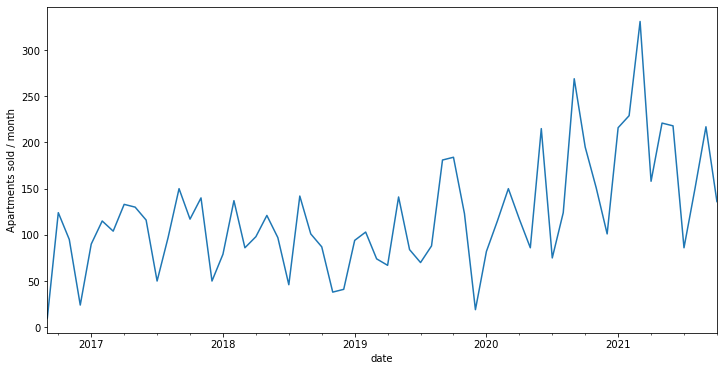

In [25]:
se.plot(figsize=(12,6))
plt.ylabel("Apartments sold / month")
plt.show()

# Forecasting of Apartments sold

In [26]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [27]:
pdf = se.to_frame().reset_index().rename(columns={'date': 'ds', 'apts_sold': 'y'})

In [59]:
model = Prophet(changepoint_prior_scale=0.5)
model.fit(pdf)

future = model.make_future_dataframe(periods=72, freq="MS")
forecast = model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -130.115
Iteration  1. Log joint probability =    28.7736. Improved by 158.889.
Iteration  2. Log joint probability =    86.0148. Improved by 57.2411.
Iteration  3. Log joint probability =    86.0183. Improved by 0.00351128.
Iteration  4. Log joint probability =    90.5687. Improved by 4.5504.
Iteration  5. Log joint probability =    90.5962. Improved by 0.0275534.
Iteration  6. Log joint probability =    90.6051. Improved by 0.00892333.
Iteration  7. Log joint probability =    90.6089. Improved by 0.00373683.
Iteration  8. Log joint probability =     90.642. Improved by 0.0331181.
Iteration  9. Log joint probability =     90.642. Improved by 3.41649e-05.
Iteration 10. Log joint probability =    90.7239. Improved by 0.0818786.
Iteration 11. Log joint probability =    90.8902. Improved by 0.166322.
Iteration 12. Log joint probability =    96.5782. Improved by 5.68795.
Iteration 13. Log joint probability =    97.7306. Improved by 1.15241.
Iteration 14. Lo

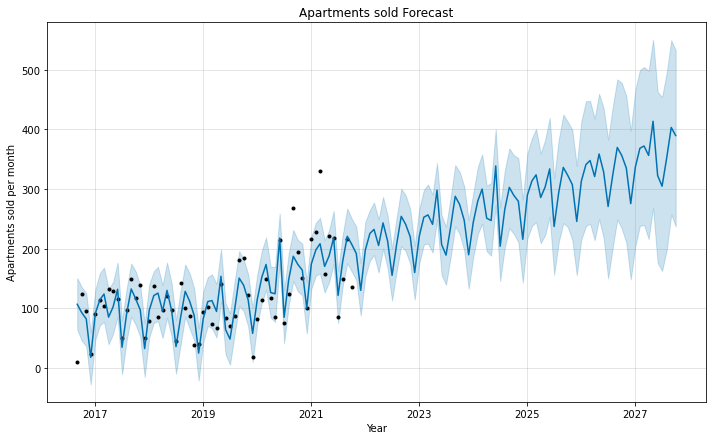

In [62]:
model.plot(forecast)
plt.title("Apartments sold Forecast")
plt.ylabel("Apartments sold per month")
plt.xlabel("Year")
plt.show()

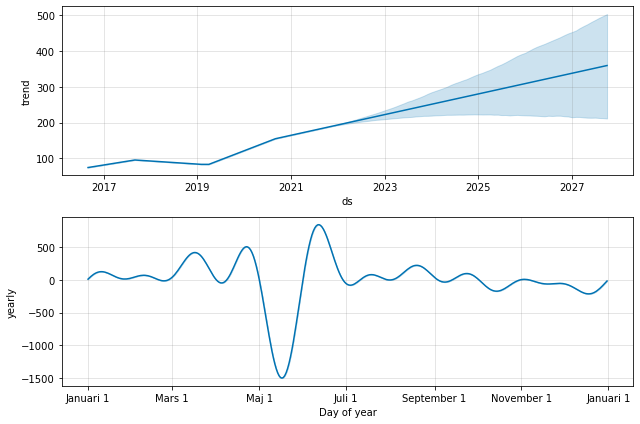

In [61]:
model.plot_components(forecast)
plt.show()

In [ ]:
# cross validation
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
    # 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    # 'changepoint_prior_scale': [0.001],
    # 'seasonality_prior_scale': [0.01]
}

cutoffs = pd.to_datetime(['2017-10-01', '2018-10-01', '2019-10-01'])
# cutoffs = pd.to_datetime(['2017-01-01'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(pdf)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses